In [1]:
import matplotlib.pyplot as plt
import os, re, json, pickle,tqdm
import scipy.io
from collections import defaultdict
import numpy as np
import warnings, logging
warnings.filterwarnings('ignore')

In [2]:
root_path = '/opt/jinhanz/results/optimize_faithfulness/mscoco/xai_saliency_maps_yolov5s/optimization'

In [3]:
layers = ['model_1_act', 'model_2_cv1_act', 'model_2_cv2_act', 'model_2_m_0_cv1_act', 'model_2_m_0_cv2_act', 'model_2_cv3_act', 'model_3_act', 'model_4_cv1_act', 'model_4_cv2_act', 'model_4_m_0_cv1_act', 'model_4_m_0_cv2_act', 'model_4_m_1_cv1_act', 'model_4_m_1_cv2_act', 'model_4_cv3_act', 'model_5_act', 'model_6_cv1_act', 'model_6_cv2_act', 'model_6_m_0_cv1_act', 'model_6_m_0_cv2_act', 'model_6_m_1_cv1_act', 'model_6_m_1_cv2_act', 'model_6_m_2_cv1_act', 'model_6_m_2_cv2_act', 'model_6_cv3_act', 'model_7_act', 'model_8_cv1_act', 'model_8_cv2_act', 'model_8_m_0_cv1_act', 'model_8_m_0_cv2_act', 'model_8_cv3_act', 'model_9_cv1_act', 'model_9_cv2_act', 'model_10_act', 'model_13_cv1_act', 'model_13_cv2_act', 'model_13_m_0_cv1_act', 'model_13_m_0_cv2_act', 'model_13_cv3_act', 'model_14_act', 'model_17_cv1_act', 'model_17_cv2_act', 'model_17_m_0_cv1_act', 'model_17_m_0_cv2_act', 'model_17_cv3_act']

In [4]:
model = [m for m in ['faster','yolov5s'] if m in root_path][0]
dataset = [d for d in ['mscoco','_vehicle','_human'] if d in root_path][0].replace('_','')
# xai_method = [x for x in ['fullgradcamraw','odam'] if x in root_path][0]
# rescale_method = [r for r in ['bilinear','sigma2','sigma4'] if r in root_path][0]
is_act = True if f"_{model}_act_" in root_path else False

print(f"{model}_{dataset}_optimize_faithfulnee: {'Activation Map' if is_act else 'Feature Map'}")

skip_images = []
if model == 'yolov5s':
    if dataset == 'mscoco':
        skip_images = ['book_472678',"baseball glove_515982","toothbrush_160666","potted plant_473219","bench_350607","truck_295420","toaster_232348","kite_405279","toothbrush_218439","snowboard_425906","car_227511","traffic light_453841","hair drier_239041","hair drier_178028","toaster_453302","mouse_513688","spoon_88040","scissors_340930","handbag_383842"]
    elif dataset == 'vehicle':
        skip_images = ["178", "54", "452", "478", "629", "758", "856",'1007', '1028', '1041', '1065', '1100', '1149', '1236', '1258', '1272', '1331', '1356', '210', '222', '3', '390', '431', '485', '505', '52', '559', '585', '634', '648', '670', '715', '784', '797', '803', '833', '848', '867', '899', '914', '940', '980', '993','1121', '1127', '1170', '1365', '321', '425', '542', '610', '896', '902', '953', '967']
    elif dataset == 'human':
        skip_images = ['1022', '1041', '1053', '1063', '1066', '1097', '11', '1141', '1142', '1154', '1227', '1228', '1273', '1293', '1302', '1313', '1346', '1359', '1398', '1420', '1430', '1475', '1506', '152', '1538', '1553', '1624', '1663', '1664', '1746', '1770', '1788', '1803', '1805', '1817', '1852', '186', '1863', '1893', '19', '1917', '1954', '2008', '2040', '2087', '2092', '2108', '2121', '2128', '2141', '2161', '2186', '2203', '2219', '2226', '2262', '2270', '2271', '2279', '231', '2312', '2327', '2334', '2457', '250', '286', '348', '388', '391', '415', '422', '425', '452', '47', '608', '670', '683', '748', '757', '805', '808', '829', '845', '85', '875', '897', '900', '928', '962', '97', '997']

yolov5s_mscoco_optimize_faithfulnee: Feature Map


In [5]:
best_sigmas_all = []
best_faithfulness_all = []
best_sigmas_by_layer = defaultdict(list)

faithfulness_all = defaultdict()
iAUC_all = defaultdict()
dAUC_all = defaultdict()

for dir in os.listdir(root_path):
    if not os.path.isdir(os.path.join(root_path,dir)): continue

    if model == 'faster':
        try:
            layer_name = re.findall(r'_[a-zA-Z0-9]+\.[a-zA-Z0-9\.]+_',dir)[0].replace('_','')
        except:
            continue
    elif model == 'yolov5s':
        try:
            layer_name = re.findall(r'_model_[a-zA-Z0-9_]+_act_',dir)[0][1:-1]
        except:
            continue

    faithfulness_layer = defaultdict(list)
    iAUC_layer = defaultdict(list)
    dAUC_layer = defaultdict(list)

    all_imgs = sorted(os.listdir(os.path.join(root_path,dir)))
    all_imgs = [f for f in all_imgs if '.json' in f]

    for img_idx, img_file in enumerate(all_imgs):
        file = json.load(open(os.path.join(root_path, dir, img_file),'r'))

        best_sigma = file['best_sigma']
        best_faithfulness = file['best_faithfulness']
        best_sigmas_all.append(best_sigma)
        best_faithfulness_all.append(best_faithfulness)
        best_sigmas_by_layer[layer_name].append(best_sigma)

        best_faithfulness_tmp = 0

        for s, step in file['attempts'].items():
            if step['faithfulness'] > best_faithfulness_tmp:
                best_faithfulness_tmp = step['faithfulness']
                iAUC_layer[img_file].append(step['iAUC'])
                dAUC_layer[img_file].append(step['dAUC'])
            else:
                iAUC_layer[img_file].append(iAUC_layer[img_file][-1])
                dAUC_layer[img_file].append(dAUC_layer[img_file][-1])
            faithfulness_layer[img_file].append(best_faithfulness_tmp)

        for s, step in file['bisection'].items():
            faithfulness_low = step['faithfulness_low']
            faithfulness_mid = step['faithfulness_mid']
            faithfulness_high = step['faithfulness_high']

            max_faithfulness_interval = max([faithfulness_low,faithfulness_mid,faithfulness_high])
            index_of_max = [faithfulness_low,faithfulness_mid,faithfulness_high].index(max_faithfulness_interval)
            max_name = ['low','mid','high'][index_of_max]

            if max_faithfulness_interval >= best_faithfulness_tmp:
                best_faithfulness_tmp = max_faithfulness_interval
                iAUC_layer[img_file].append(step[f'iAUC_{max_name}'])
                dAUC_layer[img_file].append(step[f'dAUC_{max_name}'])
            else:
                iAUC_layer[img_file].append(iAUC_layer[img_file][-1])
                dAUC_layer[img_file].append(dAUC_layer[img_file][-1])
            faithfulness_layer[img_file].append(best_faithfulness_tmp)

        assert best_faithfulness_tmp == best_faithfulness

    faithfulness_all[layer_name] = faithfulness_layer
    iAUC_all[layer_name] = iAUC_layer
    dAUC_all[layer_name] = dAUC_layer

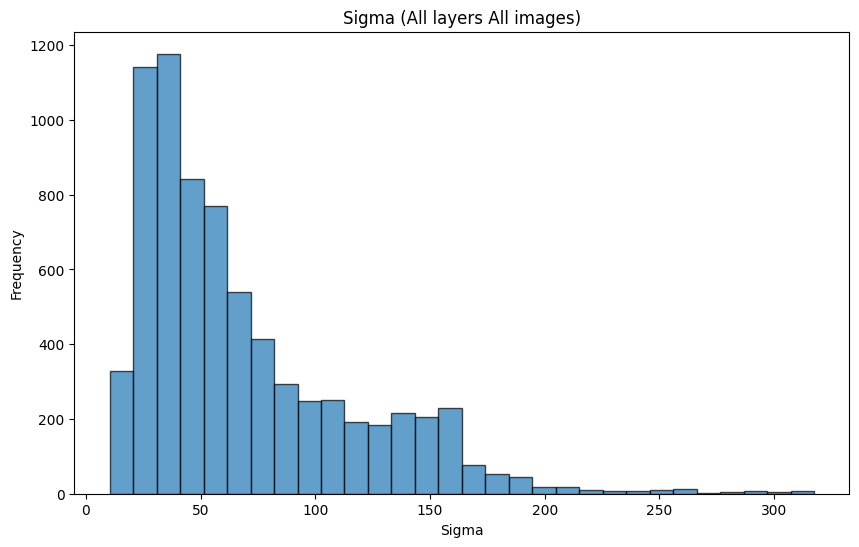

In [10]:
plt.figure(figsize=(10,6))
plt.hist(best_sigmas_all, bins=30, alpha=0.7, edgecolor='black')
plt.title('Sigma (All layers All images)')
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.show()

In [11]:
rows = 11
cols = 4
fig, axes = plt.subplots(rows,cols,figsize=(20,20))

layer_idx = 1

for i in range(rows):
    for j in range(cols):
        layer = layers[layer_idx-1]
        
        axes[i,j].hist(best_sigmas_by_layer[layer], bins=30, alpha=0.7, edgecolor='black')

        axes[i,j].set_title(f"[{layer_idx}] {layer}")
        # axes[i,j].axis('off')
        layer_idx += 1

        # axes[i,j].set_xlabel('Value')
        axes[i,j].set_xlim([0,max(best_sigmas_all)])
        # axes[i,j].set_ylabel('Frequency')

    #Hide any unused axes in the current row
    for j in range(len(layers[i]), cols):
        fig.delaxes(axes[i, j])

# plt.title('Sigma (By layer)')
plt.tight_layout()
plt.show()

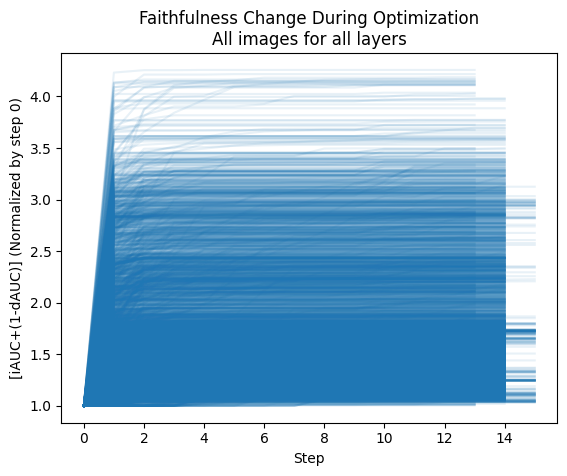

In [6]:
for l, faithfulness_layer in faithfulness_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')
plt.xlabel('Step')
plt.ylabel('[iAUC+(1-dAUC)] (Normalized by step 0)')
plt.title('Faithfulness Change During Optimization\nAll images for all layers')
plt.show()

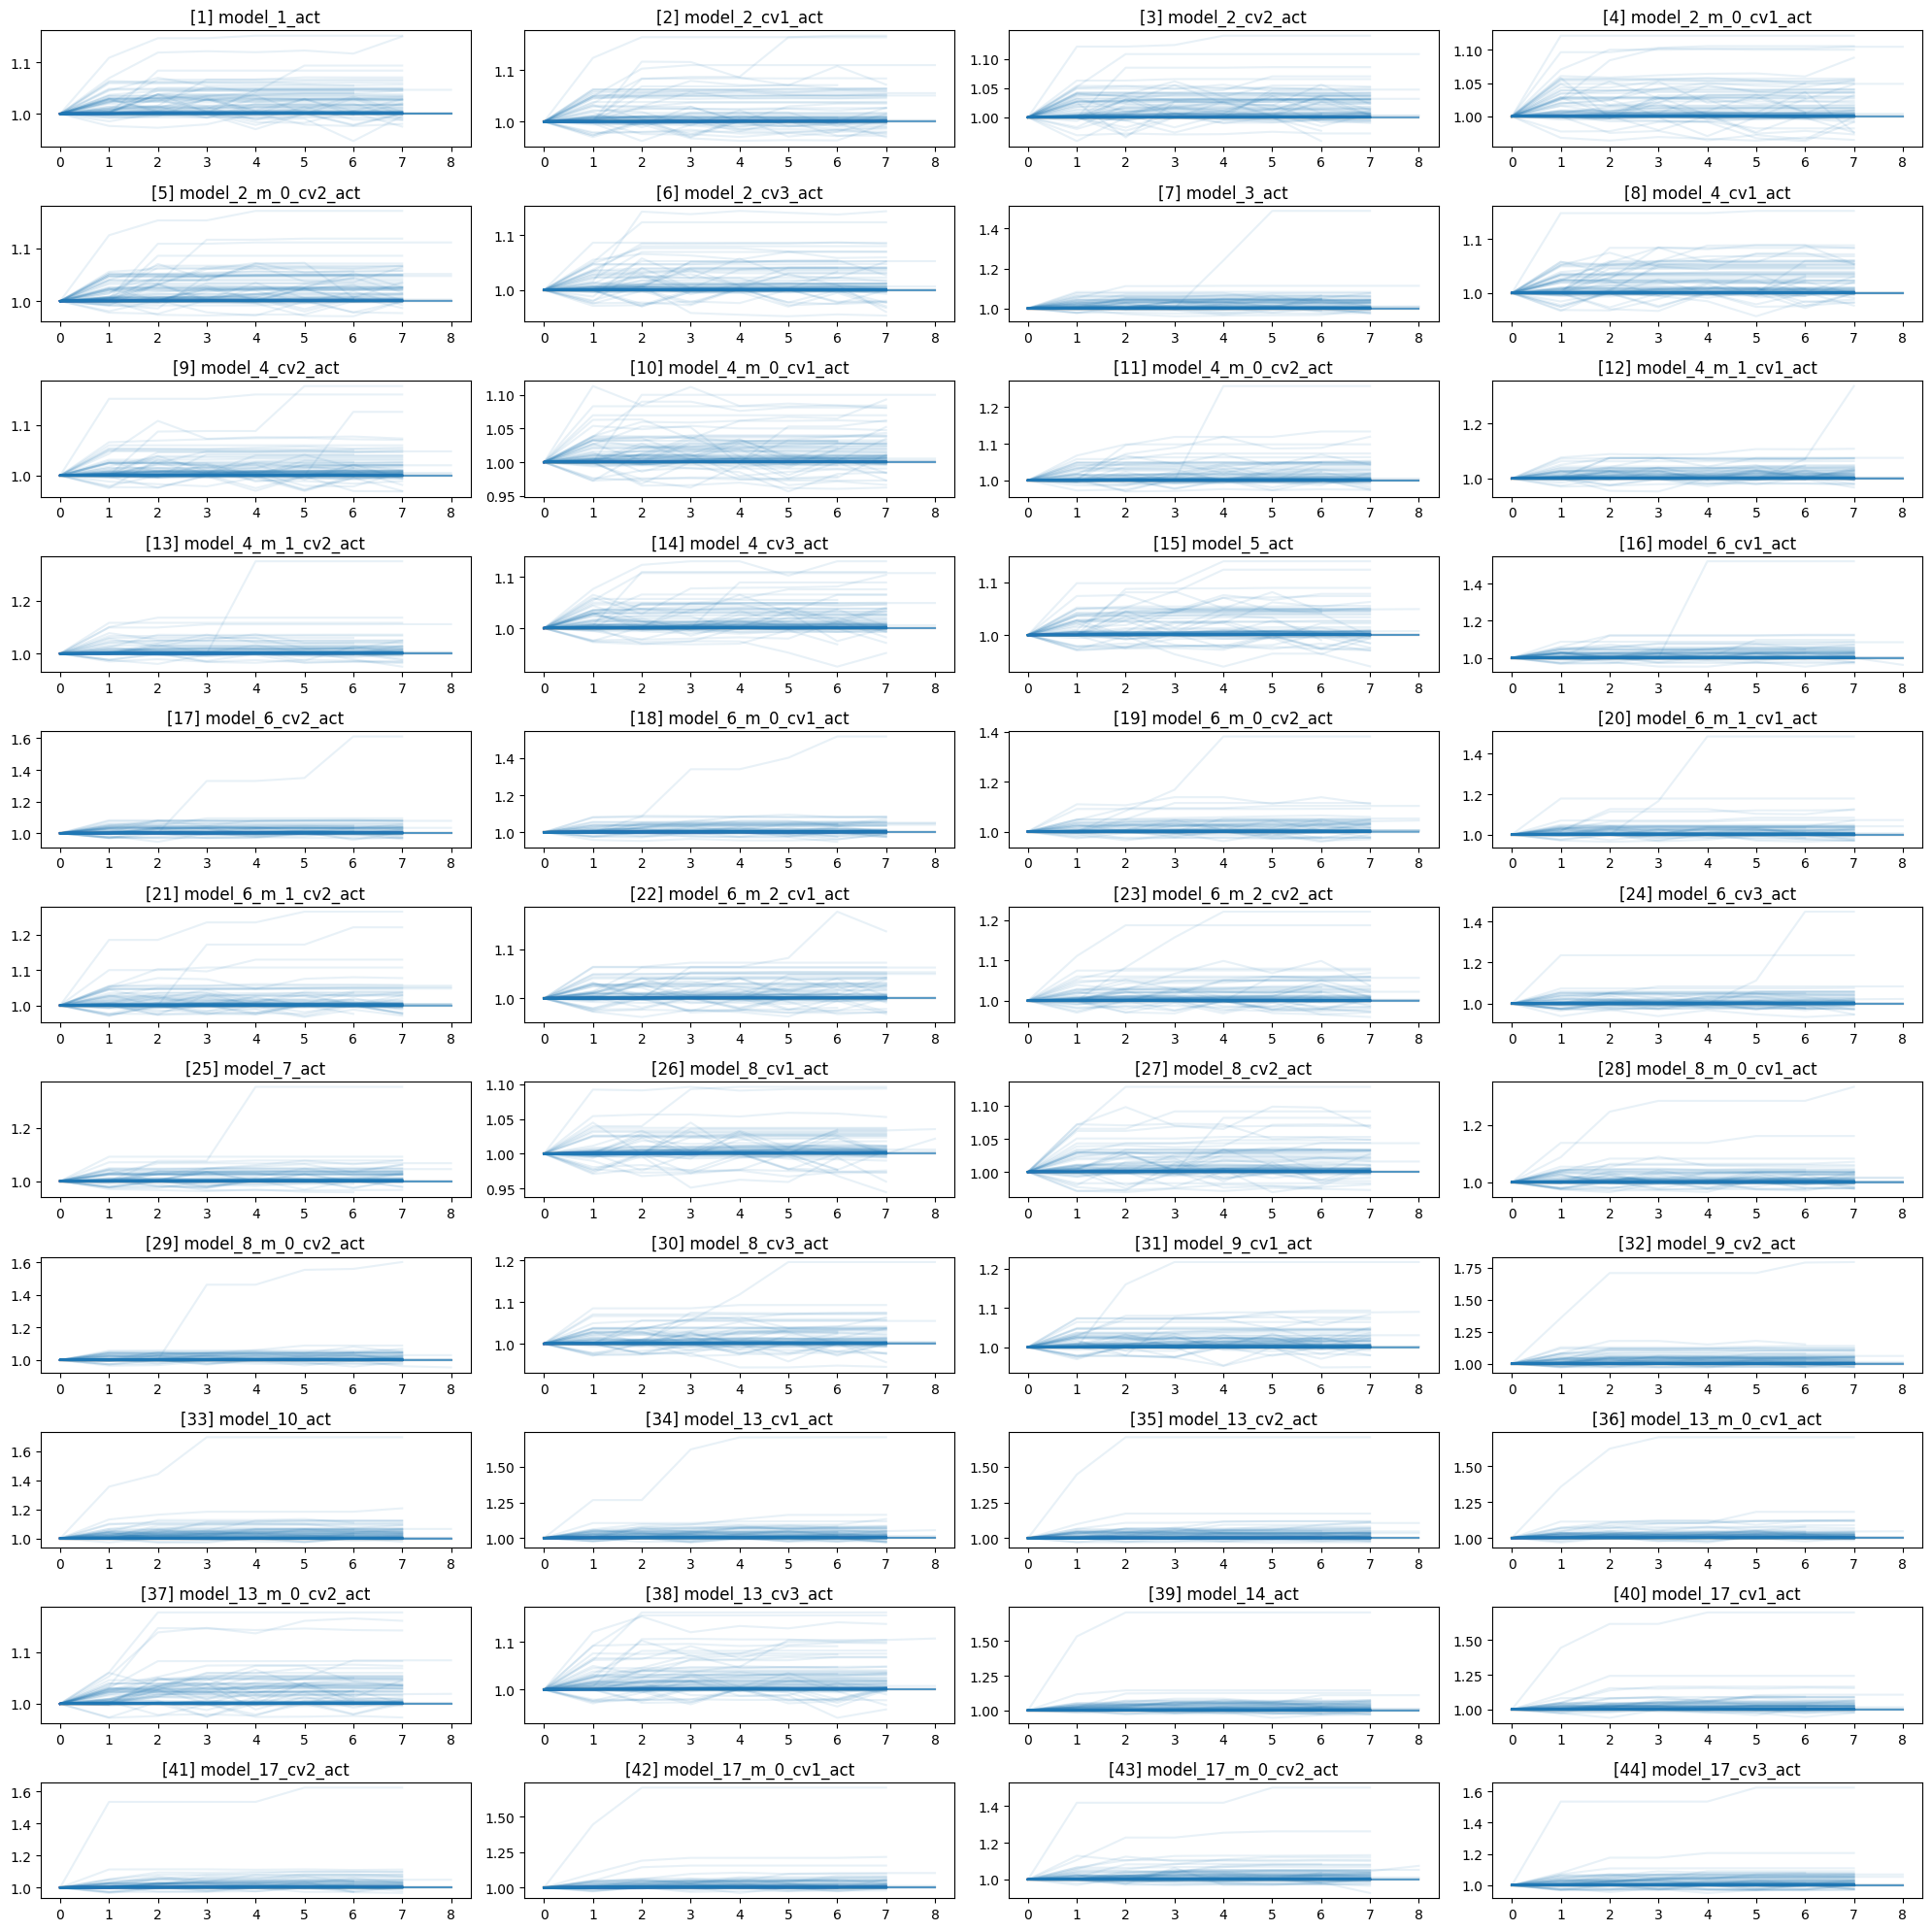

In [10]:
rows = 11
cols = 4
fig, axes = plt.subplots(rows,cols,figsize=(20,20))

layer_idx = 1

for i in range(rows):
    for j in range(cols):
        layer = layers[layer_idx-1]

        for img_idx,img in faithfulness_all[layer].items():
            axes[i,j].plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')

        axes[i,j].set_title(f"[{layer_idx}] {layer}")
        # axes[i,j].axis('off')
        layer_idx += 1

        # axes[i,j].set_xlabel('Value')
        # axes[i,j].set_ylabel('Frequency')

    #Hide any unused axes in the current row
    for j in range(len(layers[i]), cols):
        fig.delaxes(axes[i, j])

# plt.title('Sigma (By layer)')
plt.tight_layout()
plt.show()

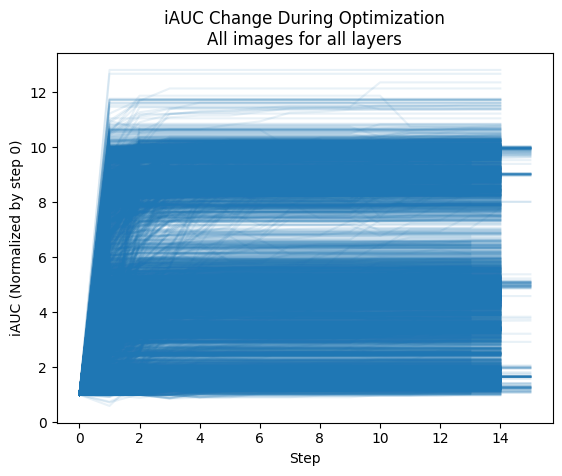

In [9]:
for l, faithfulness_layer in iAUC_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')
# plt.ylim([0,3])
plt.xlabel('Step')
plt.ylabel('iAUC (Normalized by step 0)')
plt.title('iAUC Change During Optimization\nAll images for all layers')
plt.show()

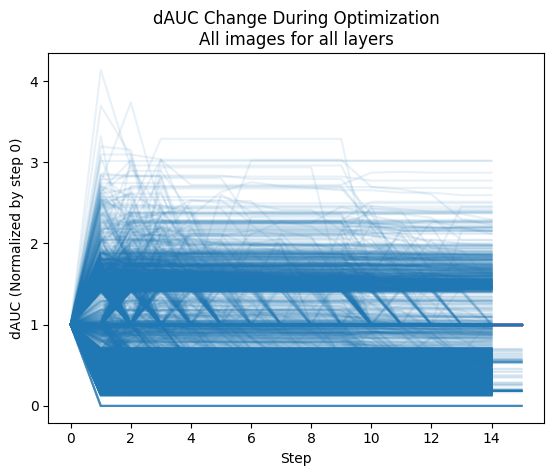

In [8]:
for l, faithfulness_layer in dAUC_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')
plt.xlabel('Step')
plt.ylabel('dAUC (Normalized by step 0)')
plt.title('dAUC Change During Optimization\nAll images for all layers')
plt.show()